# Data Augmentation on Sample from Dataset

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Folders for input (original images) and output (original + augmented images)
in_folder = r"dataset/"
out_folder = r"dataset-augmented/"

In [3]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [4]:
# Convert PIL Image to tensor
to_tensor = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

translation_matrix = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Transformations to apply to inputs, where one is randomly chosen and applied per image
augmentations = transforms.RandomChoice([
    # Rotate by a random amount within -2 to -1 degrees
    transforms.RandomRotation(degrees=(-2, -1), fill=255), 
    
    # Rotate by a random amount within 1 to 2 degrees
    transforms.RandomRotation(degrees=(1, 2), fill=255), 
    
    # Translate horizontally by a random percentage between -10% and 10% and
    # vertically by a random percentage between -10% and 10%
    
    
    
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=255), 
    
    # Horizontally flips the image
    transforms.RandomHorizontalFlip(p=1)
])

In [5]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Augment Data

In [6]:
# Image dataset
class AugmentedDataset(Dataset):
    def __init__(self, img_dir, to_tensor, augment):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",")
        self.to_tensor = to_tensor
        self.augment = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Augment image
        image = Image.open(img_path).convert("RGB")
        image = self.to_tensor(image)
        image = self.augment(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label, filename

In [7]:
# Dataset and dataloader for images
data = AugmentedDataset(img_dir=in_folder, to_tensor=to_tensor, augment=augmentations)
loader = DataLoader(data, batch_size=10, shuffle=True)

### Show Sample of Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes: 0 0 0 1 0 0 0 0 0 1
Original files:
0729-0-P.tif
0220-0-A.tif
0814-0-A.tif
0191-1-P.tif
0085-0-P.tif
1151-0-P.tif
0371-0-P.tif
0678-0-A.tif
0752-0-A.tif
0760-1-A.tif


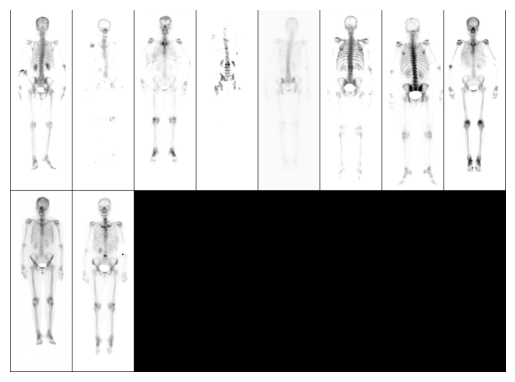

In [8]:
# Show random augmented images and their ground truth classes
dataiter = iter(loader)
images, labels, filenames = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))
print("Original files:\n" + '\n'.join(f'{filenames[j]}' for j in range(len(filenames))))

### Save Augmented Data as Images

In [9]:
# Get index of last original image, used to create filenames for augmented images
last_filename = os.listdir(in_folder)[-1]
img_index = int(last_filename[0:4])

In [10]:
for batch_index, batch_data in enumerate(loader):
    # Get the images, labels, and filenames in the current batch
    images, labels, orig_filenames = batch_data
    
    for i in range(len(images)):
        # Create filename for augmented image
        img_index += 1
        new_filename = str(img_index) + orig_filenames[i][4:]
        img_path = out_folder + "/" + new_filename
        
        # Save augmented image
        save_image(images[i], img_path)
        print(f"Saved augmented copy of {orig_filenames[i]} as {new_filename} in {out_folder}")

Saved augmented copy of 0616-0-A.tif as 1226-0-A.tif in dataset-augmented/
Saved augmented copy of 1148-0-P.tif as 1227-0-P.tif in dataset-augmented/
Saved augmented copy of 0752-0-A.tif as 1228-0-A.tif in dataset-augmented/
Saved augmented copy of 0021-1-P.tif as 1229-1-P.tif in dataset-augmented/
Saved augmented copy of 0682-1-A.tif as 1230-1-A.tif in dataset-augmented/
Saved augmented copy of 0687-1-P.tif as 1231-1-P.tif in dataset-augmented/
Saved augmented copy of 1050-0-P.tif as 1232-0-P.tif in dataset-augmented/
Saved augmented copy of 0831-0-A.tif as 1233-0-A.tif in dataset-augmented/
Saved augmented copy of 0716-1-A.tif as 1234-1-A.tif in dataset-augmented/
Saved augmented copy of 0837-0-A.tif as 1235-0-A.tif in dataset-augmented/
Saved augmented copy of 1163-0-P.tif as 1236-0-P.tif in dataset-augmented/
Saved augmented copy of 1125-0-P.tif as 1237-0-P.tif in dataset-augmented/
Saved augmented copy of 1224-1-P.tif as 1238-1-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0598-1-A.tif as 1336-1-A.tif in dataset-augmented/
Saved augmented copy of 0791-0-P.tif as 1337-0-P.tif in dataset-augmented/
Saved augmented copy of 0707-1-P.tif as 1338-1-P.tif in dataset-augmented/
Saved augmented copy of 0872-0-A.tif as 1339-0-A.tif in dataset-augmented/
Saved augmented copy of 0097-1-P.tif as 1340-1-P.tif in dataset-augmented/
Saved augmented copy of 0761-1-P.tif as 1341-1-P.tif in dataset-augmented/
Saved augmented copy of 0719-1-P.tif as 1342-1-P.tif in dataset-augmented/
Saved augmented copy of 0374-0-A.tif as 1343-0-A.tif in dataset-augmented/
Saved augmented copy of 1212-1-P.tif as 1344-1-P.tif in dataset-augmented/
Saved augmented copy of 0063-0-P.tif as 1345-0-P.tif in dataset-augmented/
Saved augmented copy of 0431-0-P.tif as 1346-0-P.tif in dataset-augmented/
Saved augmented copy of 0825-0-A.tif as 1347-0-A.tif in dataset-augmented/
Saved augmented copy of 0842-0-A.tif as 1348-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0620-0-A.tif as 1446-0-A.tif in dataset-augmented/
Saved augmented copy of 0210-1-A.tif as 1447-1-A.tif in dataset-augmented/
Saved augmented copy of 0523-0-P.tif as 1448-0-P.tif in dataset-augmented/
Saved augmented copy of 0475-1-P.tif as 1449-1-P.tif in dataset-augmented/
Saved augmented copy of 0014-0-A.tif as 1450-0-A.tif in dataset-augmented/
Saved augmented copy of 0001-0-P.tif as 1451-0-P.tif in dataset-augmented/
Saved augmented copy of 0868-0-A.tif as 1452-0-A.tif in dataset-augmented/
Saved augmented copy of 0894-0-A.tif as 1453-0-A.tif in dataset-augmented/
Saved augmented copy of 0409-1-P.tif as 1454-1-P.tif in dataset-augmented/
Saved augmented copy of 0182-0-A.tif as 1455-0-A.tif in dataset-augmented/
Saved augmented copy of 1040-0-P.tif as 1456-0-P.tif in dataset-augmented/
Saved augmented copy of 1153-0-P.tif as 1457-0-P.tif in dataset-augmented/
Saved augmented copy of 1055-0-P.tif as 1458-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0226-1-A.tif as 1556-1-A.tif in dataset-augmented/
Saved augmented copy of 0359-1-P.tif as 1557-1-P.tif in dataset-augmented/
Saved augmented copy of 0430-0-A.tif as 1558-0-A.tif in dataset-augmented/
Saved augmented copy of 0317-1-P.tif as 1559-1-P.tif in dataset-augmented/
Saved augmented copy of 0379-1-P.tif as 1560-1-P.tif in dataset-augmented/
Saved augmented copy of 0280-1-A.tif as 1561-1-A.tif in dataset-augmented/
Saved augmented copy of 0344-0-A.tif as 1562-0-A.tif in dataset-augmented/
Saved augmented copy of 0034-0-A.tif as 1563-0-A.tif in dataset-augmented/
Saved augmented copy of 0345-0-P.tif as 1564-0-P.tif in dataset-augmented/
Saved augmented copy of 0760-1-A.tif as 1565-1-A.tif in dataset-augmented/
Saved augmented copy of 0869-0-A.tif as 1566-0-A.tif in dataset-augmented/
Saved augmented copy of 0165-1-P.tif as 1567-1-P.tif in dataset-augmented/
Saved augmented copy of 0918-0-A.tif as 1568-0-A.tif in dataset-augmented/
Saved augmented copy of 1

Saved augmented copy of 0773-0-P.tif as 1666-0-P.tif in dataset-augmented/
Saved augmented copy of 0873-0-A.tif as 1667-0-A.tif in dataset-augmented/
Saved augmented copy of 0983-1-A.tif as 1668-1-A.tif in dataset-augmented/
Saved augmented copy of 0116-1-A.tif as 1669-1-A.tif in dataset-augmented/
Saved augmented copy of 0888-0-A.tif as 1670-0-A.tif in dataset-augmented/
Saved augmented copy of 0257-1-P.tif as 1671-1-P.tif in dataset-augmented/
Saved augmented copy of 0170-1-A.tif as 1672-1-A.tif in dataset-augmented/
Saved augmented copy of 0285-1-P.tif as 1673-1-P.tif in dataset-augmented/
Saved augmented copy of 0895-0-A.tif as 1674-0-A.tif in dataset-augmented/
Saved augmented copy of 0119-1-P.tif as 1675-1-P.tif in dataset-augmented/
Saved augmented copy of 0617-0-P.tif as 1676-0-P.tif in dataset-augmented/
Saved augmented copy of 0057-1-A.tif as 1677-1-A.tif in dataset-augmented/
Saved augmented copy of 1205-1-P.tif as 1678-1-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0899-0-A.tif as 1776-0-A.tif in dataset-augmented/
Saved augmented copy of 0530-0-P.tif as 1777-0-P.tif in dataset-augmented/
Saved augmented copy of 1104-0-P.tif as 1778-0-P.tif in dataset-augmented/
Saved augmented copy of 1018-0-P.tif as 1779-0-P.tif in dataset-augmented/
Saved augmented copy of 0755-1-P.tif as 1780-1-P.tif in dataset-augmented/
Saved augmented copy of 0933-0-A.tif as 1781-0-A.tif in dataset-augmented/
Saved augmented copy of 0437-0-P.tif as 1782-0-P.tif in dataset-augmented/
Saved augmented copy of 0300-1-A.tif as 1783-1-A.tif in dataset-augmented/
Saved augmented copy of 0200-0-A.tif as 1784-0-A.tif in dataset-augmented/
Saved augmented copy of 0406-0-P.tif as 1785-0-P.tif in dataset-augmented/
Saved augmented copy of 0293-1-P.tif as 1786-1-P.tif in dataset-augmented/
Saved augmented copy of 0408-1-A.tif as 1787-1-A.tif in dataset-augmented/
Saved augmented copy of 1222-1-P.tif as 1788-1-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 1135-0-P.tif as 1886-0-P.tif in dataset-augmented/
Saved augmented copy of 0099-0-P.tif as 1887-0-P.tif in dataset-augmented/
Saved augmented copy of 0138-0-A.tif as 1888-0-A.tif in dataset-augmented/
Saved augmented copy of 0423-1-P.tif as 1889-1-P.tif in dataset-augmented/
Saved augmented copy of 0852-0-A.tif as 1890-0-A.tif in dataset-augmented/
Saved augmented copy of 0161-1-P.tif as 1891-1-P.tif in dataset-augmented/
Saved augmented copy of 0088-1-A.tif as 1892-1-A.tif in dataset-augmented/
Saved augmented copy of 0577-0-P.tif as 1893-0-P.tif in dataset-augmented/
Saved augmented copy of 0817-0-A.tif as 1894-0-A.tif in dataset-augmented/
Saved augmented copy of 0253-1-P.tif as 1895-1-P.tif in dataset-augmented/
Saved augmented copy of 0241-1-P.tif as 1896-1-P.tif in dataset-augmented/
Saved augmented copy of 0877-0-A.tif as 1897-0-A.tif in dataset-augmented/
Saved augmented copy of 0454-0-A.tif as 1898-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 1215-1-P.tif as 1996-1-P.tif in dataset-augmented/
Saved augmented copy of 0623-0-P.tif as 1997-0-P.tif in dataset-augmented/
Saved augmented copy of 1137-0-P.tif as 1998-0-P.tif in dataset-augmented/
Saved augmented copy of 0348-1-A.tif as 1999-1-A.tif in dataset-augmented/
Saved augmented copy of 0925-0-A.tif as 2000-0-A.tif in dataset-augmented/
Saved augmented copy of 1129-0-P.tif as 2001-0-P.tif in dataset-augmented/
Saved augmented copy of 0368-1-A.tif as 2002-1-A.tif in dataset-augmented/
Saved augmented copy of 0746-0-A.tif as 2003-0-A.tif in dataset-augmented/
Saved augmented copy of 0574-1-A.tif as 2004-1-A.tif in dataset-augmented/
Saved augmented copy of 1003-1-A.tif as 2005-1-A.tif in dataset-augmented/
Saved augmented copy of 0643-0-P.tif as 2006-0-P.tif in dataset-augmented/
Saved augmented copy of 1002-1-A.tif as 2007-1-A.tif in dataset-augmented/
Saved augmented copy of 0152-0-P.tif as 2008-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0584-1-A.tif as 2106-1-A.tif in dataset-augmented/
Saved augmented copy of 0570-0-A.tif as 2107-0-A.tif in dataset-augmented/
Saved augmented copy of 0067-0-P.tif as 2108-0-P.tif in dataset-augmented/
Saved augmented copy of 0395-0-P.tif as 2109-0-P.tif in dataset-augmented/
Saved augmented copy of 0381-0-P.tif as 2110-0-P.tif in dataset-augmented/
Saved augmented copy of 1054-0-P.tif as 2111-0-P.tif in dataset-augmented/
Saved augmented copy of 0365-0-P.tif as 2112-0-P.tif in dataset-augmented/
Saved augmented copy of 0424-0-A.tif as 2113-0-A.tif in dataset-augmented/
Saved augmented copy of 0841-0-A.tif as 2114-0-A.tif in dataset-augmented/
Saved augmented copy of 0860-0-A.tif as 2115-0-A.tif in dataset-augmented/
Saved augmented copy of 0484-0-A.tif as 2116-0-A.tif in dataset-augmented/
Saved augmented copy of 1024-0-P.tif as 2117-0-P.tif in dataset-augmented/
Saved augmented copy of 0174-1-A.tif as 2118-1-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0323-1-P.tif as 2216-1-P.tif in dataset-augmented/
Saved augmented copy of 0101-1-P.tif as 2217-1-P.tif in dataset-augmented/
Saved augmented copy of 0325-0-P.tif as 2218-0-P.tif in dataset-augmented/
Saved augmented copy of 0639-1-A.tif as 2219-1-A.tif in dataset-augmented/
Saved augmented copy of 0701-1-P.tif as 2220-1-P.tif in dataset-augmented/
Saved augmented copy of 1093-0-P.tif as 2221-0-P.tif in dataset-augmented/
Saved augmented copy of 0087-0-P.tif as 2222-0-P.tif in dataset-augmented/
Saved augmented copy of 0917-0-A.tif as 2223-0-A.tif in dataset-augmented/
Saved augmented copy of 0082-0-A.tif as 2224-0-A.tif in dataset-augmented/
Saved augmented copy of 0862-0-A.tif as 2225-0-A.tif in dataset-augmented/
Saved augmented copy of 0275-1-P.tif as 2226-1-P.tif in dataset-augmented/
Saved augmented copy of 0350-1-A.tif as 2227-1-A.tif in dataset-augmented/
Saved augmented copy of 0733-0-P.tif as 2228-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 1174-0-P.tif as 2326-0-P.tif in dataset-augmented/
Saved augmented copy of 0806-0-A.tif as 2327-0-A.tif in dataset-augmented/
Saved augmented copy of 0700-1-A.tif as 2328-1-A.tif in dataset-augmented/
Saved augmented copy of 0136-0-A.tif as 2329-0-A.tif in dataset-augmented/
Saved augmented copy of 0565-0-P.tif as 2330-0-P.tif in dataset-augmented/
Saved augmented copy of 1069-0-P.tif as 2331-0-P.tif in dataset-augmented/
Saved augmented copy of 1065-0-P.tif as 2332-0-P.tif in dataset-augmented/
Saved augmented copy of 0731-1-A.tif as 2333-1-A.tif in dataset-augmented/
Saved augmented copy of 1197-1-P.tif as 2334-1-P.tif in dataset-augmented/
Saved augmented copy of 1042-0-P.tif as 2335-0-P.tif in dataset-augmented/
Saved augmented copy of 1196-1-P.tif as 2336-1-P.tif in dataset-augmented/
Saved augmented copy of 1017-0-P.tif as 2337-0-P.tif in dataset-augmented/
Saved augmented copy of 0636-0-A.tif as 2338-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0624-0-A.tif as 2437-0-A.tif in dataset-augmented/
Saved augmented copy of 1188-1-P.tif as 2438-1-P.tif in dataset-augmented/
Saved augmented copy of 0468-1-A.tif as 2439-1-A.tif in dataset-augmented/
Saved augmented copy of 0463-1-A.tif as 2440-1-A.tif in dataset-augmented/
Saved augmented copy of 1060-0-P.tif as 2441-0-P.tif in dataset-augmented/
Saved augmented copy of 0451-1-P.tif as 2442-1-P.tif in dataset-augmented/
Saved augmented copy of 1210-1-P.tif as 2443-1-P.tif in dataset-augmented/
Saved augmented copy of 0622-0-A.tif as 2444-0-A.tif in dataset-augmented/
Saved augmented copy of 0969-1-A.tif as 2445-1-A.tif in dataset-augmented/
Saved augmented copy of 1150-0-P.tif as 2446-0-P.tif in dataset-augmented/
Saved augmented copy of 0306-1-A.tif as 2447-1-A.tif in dataset-augmented/
Saved augmented copy of 0351-1-P.tif as 2448-1-P.tif in dataset-augmented/
Saved augmented copy of 0566-0-A.tif as 2449-0-A.tif in dataset-augmented/
Saved augmented copy of 1